In [2]:
!pip install seaborn


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Found 2 files.
Processing P20251212180941_009339_responses.json -> FORCING as Run 1
Processing P20251212171849_bb426a_responses.json -> FORCING as Run 4

 ANALYSIS: 4 CONDITIONS (Map/Text x With/Without)

--- Accuracy (%) by Condition ---


framework,with_framework,without_framework
view_type,,
map,66.666667,66.666667
text,83.333333,33.333333


/tmp/ipykernel_119295/1407312710.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_plot, x='Condition', y=acc_plot['is_correct']*100, palette="viridis")


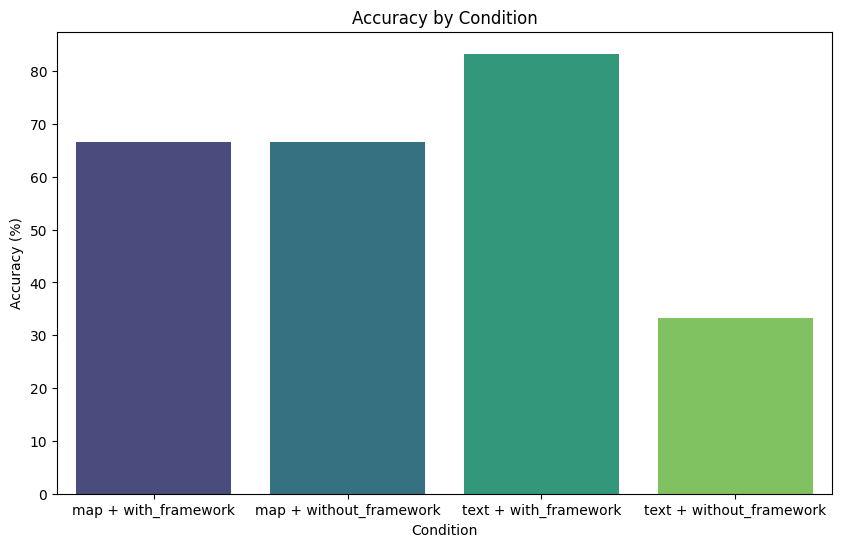


--- NASA-TLX Scores by Condition ---


mental_demand  physical_demand  temporal_demand  \
view_type framework                                                            
map       with_framework               1.5              1.5              2.5   
          without_framework            2.5              2.0              3.5   
text      with_framework               2.5              2.5              3.0   
          without_framework            4.0              3.0              4.0   

                             performance  effort  frustration  
view_type framework                                            
map       with_framework             4.5     2.0          1.5  
          without_framework          3.5     2.5          2.5  
text      with_framework             3.5     2.5          2.0  
          without_framework          3.0     4.0          3.5

/tmp/ipykernel_119295/1407312710.py:180: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='Condition', palette="Set2", ci=None)


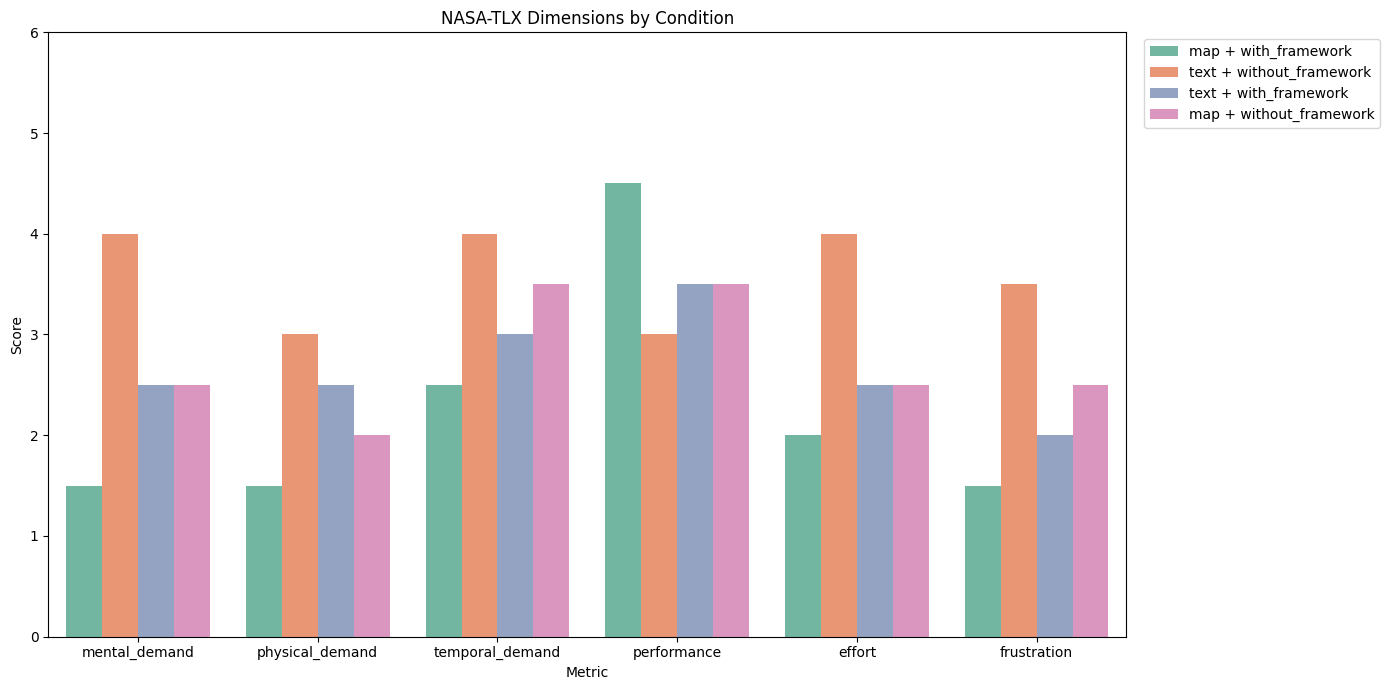


 ANALYSIS: RUN 1 vs RUN 4 (Learning Effect)

Accuracy % (Run 1 vs Run 4):
run_number
1    83.333333
4    41.666667
Name: is_correct, dtype: float64

NASA-TLX (Run 1 vs Run 4):
run_number
1    2.33
4    3.29
Name: Overall_Workload, dtype: float64


In [18]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. CONFIGURATION: FORCE RUN NUMBERS
# ==========================================

# We force specific files to be treated as specific runs.
FILE_RUN_MAPPING = {
    "009339": 1,  # Force this file to be Run 1
    "bb426a": 4   # Force this file to be Run 4
}

# Answer Key
answer_key = {
    1: {1: "Yes", 2: "SW", 3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"},
    2: {1: {"Robot 1", "Robot 3"}, 2: "Robot 3 is encountering bad weather", 3: "Robot 2"},
    3: {1: "Replanning due to bad weather", 2: "Robot 2 will have to replan its route", 3: "Robot 2"},
    4: {1: "NE", 2: "Robot 3 discovered a package in the NE and is delivering it to the NW", 3: "NW"},
    5: {1: "Just delivered a package", 2: "Robot 2 will head towards a different package in the SW quadrant", 3: "Robot 2"},
    6: {1: {"Robot 2", "Robot 3"}, 2: "Both robots are experiencing poor weather", 3: "Robot 3 will return to the SE"}
}

def normalize(val):
    if isinstance(val, str):
        val = val.lower().strip()
        for prefix in ["a. ", "b. ", "c. ", "d. "]:
            if val.startswith(prefix): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    if correct_answer is None: return False
    
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            return {normalize(x) for x in user_answer} == {normalize(x) for x in correct_answer}
        return False
    return normalize(user_answer) == normalize(correct_answer)

# ==========================================
# 2. DATA LOADING
# ==========================================

tlx_data = []
accuracy_data = []

files = glob.glob('*.json')
print(f"Found {len(files)} files.")

for file_path in files:
    # 1. Determine the Forced Run Number based on filename
    forced_run = None
    for key, run_num in FILE_RUN_MAPPING.items():
        if key in file_path:
            forced_run = run_num
            break
            
    if forced_run is None:
        continue

    print(f"Processing {file_path} -> FORCING as Run {forced_run}")

    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except:
            continue

    for entry in data:
        etype = entry.get('type')
        
        # Use the forced run number
        current_run = forced_run 

        # --- NASA-TLX ---
        if etype == 'post_scenario':
            fw = entry.get('framework', 'Unknown')
            vt = entry.get('view_type', 'Unknown')
            scenario = entry.get('scenario')
            
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'run_number': current_run,
                'scenario': scenario,  # Crucial for unique ID
                'framework': fw,
                'view_type': vt,
                'Condition': f"{vt} + {fw}"
            }
            for metric in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
                val = answers.get(metric)
                if val and isinstance(val, str):
                    try:
                        row[metric] = int(val.split(' - ')[0])
                    except:
                        row[metric] = None
            tlx_data.append(row)

        # --- Accuracy ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            q_idx = entry.get('pause_point')
            is_correct = check_answer(scenario, q_idx, entry.get('answer'))
            
            accuracy_data.append({
                'file': file_path,
                'run_number': current_run,
                'scenario': scenario,
                'question': q_idx,
                'is_correct': is_correct
            })

df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

# ==========================================
# 3. MERGE METADATA (FIXED)
# ==========================================
if not df_tlx.empty and not df_acc.empty:
    # FIX: We map using (file, run, scenario) to ensure uniqueness
    # We also drop duplicates just in case the data has weird retries
    unique_tlx = df_tlx.drop_duplicates(subset=['file', 'run_number', 'scenario'])
    
    meta_map = unique_tlx.set_index(['file', 'run_number', 'scenario'])[['framework', 'view_type', 'Condition']].to_dict('index')

    def get_meta(row):
        # We look up using the specific scenario ID
        key = (row['file'], row['run_number'], row['scenario'])
        if key in meta_map:
            return pd.Series(meta_map[key])
        return pd.Series(['Unknown', 'Unknown', 'Unknown'], index=['framework', 'view_type', 'Condition'])

    df_acc[['framework', 'view_type', 'Condition']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 4. ANALYSIS & VISUALIZATION
# ==========================================

if not df_tlx.empty:
    print("\n" + "="*50)
    print(" ANALYSIS: 4 CONDITIONS (Map/Text x With/Without)")
    print("="*50)

    # --- A. ACCURACY TABLE ---
    if not df_acc.empty:
        print("\n--- Accuracy (%) by Condition ---")
        # Ensure we drop rows where condition is Unknown
        clean_acc = df_acc[df_acc['Condition'] != 'Unknown']
        if not clean_acc.empty:
            acc_stats = clean_acc.groupby(['view_type', 'framework'])['is_correct'].mean() * 100
            display(acc_stats.unstack()) 

            # Plot Accuracy
            plt.figure(figsize=(10, 6))
            acc_plot = clean_acc.groupby('Condition')['is_correct'].mean().reset_index()
            # acc_plot['is_correct'] is already 0-1 mean, so multiply by 100 for display
            sns.barplot(data=acc_plot, x='Condition', y=acc_plot['is_correct']*100, palette="viridis")
            plt.title("Accuracy by Condition")
            plt.ylabel("Accuracy (%)")
            plt.show()
        else:
            print("No matching condition data found for accuracy (check scenario IDs).")

    # --- B. WORKLOAD (NASA-TLX) TABLE ---
    print("\n--- NASA-TLX Scores by Condition ---")
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    tlx_stats = df_tlx.groupby(['view_type', 'framework'])[tlx_cols].mean().round(2)
    display(tlx_stats)

    # Plot TLX Grouped
    df_melt = df_tlx.melt(id_vars=['Condition'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='Condition', palette="Set2", ci=None)
    plt.title("NASA-TLX Dimensions by Condition")
    plt.ylim(0, 6)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- C. RUN 1 vs RUN 4 (Learning Effect) ---
    print("\n" + "="*50)
    print(" ANALYSIS: RUN 1 vs RUN 4 (Learning Effect)")
    print("="*50)
    
    # Accuracy Learning
    if not df_acc.empty:
        print("\nAccuracy % (Run 1 vs Run 4):")
        print(df_acc.groupby('run_number')['is_correct'].mean() * 100)
    
    # Workload Learning
    print("\nNASA-TLX (Run 1 vs Run 4):")
    df_tlx['Overall_Workload'] = df_tlx[tlx_cols].mean(axis=1)
    print(df_tlx.groupby('run_number')['Overall_Workload'].mean().round(2))

Found 2 files. Filtering for targets...
Processing P20251212180941_009339_responses.json -> Extracting Run 4
Processing P20251212171849_bb426a_responses.json -> Extracting Run 1

 COMPARISON: RUN 1 vs RUN 4

--- NASA-TLX Scores (Run 1 vs Run 4) ---


,mental_demand,physical_demand,temporal_demand,performance,effort,frustration
run_number,,,,,,
1,3.0,3.0,4.0,3.0,3.0,3.0
4,2.0,1.0,3.0,4.0,2.0,2.0


/tmp/ipykernel_119295/2987479217.py:174: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt_run, x='Metric', y='Score', hue='run_number', palette="coolwarm", ci=None)


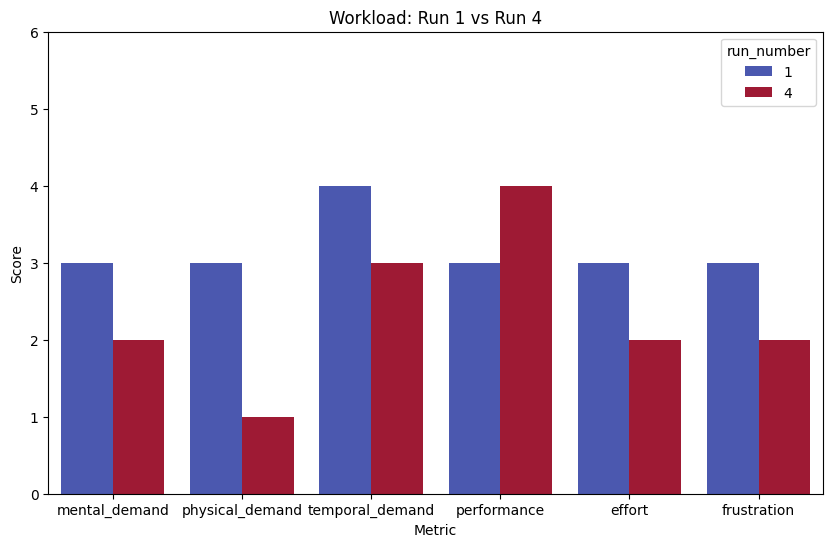


--- Accuracy % (Run 1 vs Run 4) ---
run_number
1     33.333333
4    100.000000
Name: is_correct, dtype: float64


/tmp/ipykernel_119295/2987479217.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_plot_run, x='run_number', y='is_correct', palette="coolwarm")


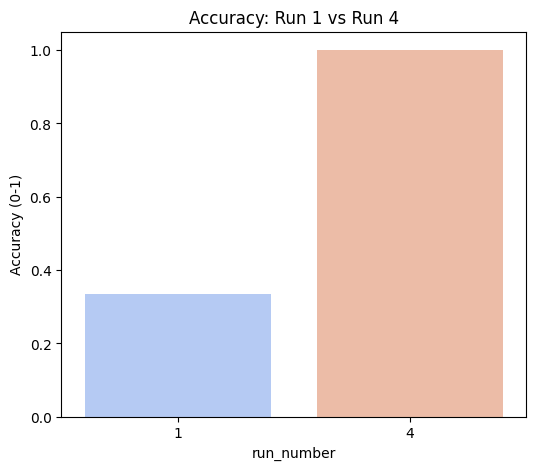


 COMPARISON: WITH FRAMEWORK vs WITHOUT

--- NASA-TLX Scores (Framework) ---


,mental_demand,physical_demand,temporal_demand,performance,effort,frustration
framework,,,,,,
without_framework,2.5,2.0,3.5,3.5,2.5,2.5


/tmp/ipykernel_119295/2987479217.py:208: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt_fw, x='Metric', y='Score', hue='framework', palette="viridis", ci=None)


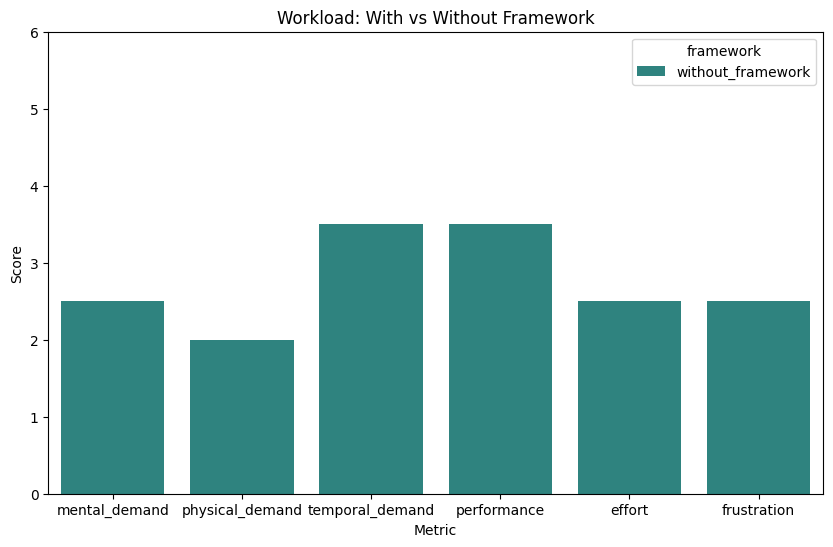


--- Accuracy % (Framework) ---
framework
without_framework    66.666667
Name: is_correct, dtype: float64


/tmp/ipykernel_119295/2987479217.py:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_plot_fw, x='framework', y='is_correct', palette="viridis")


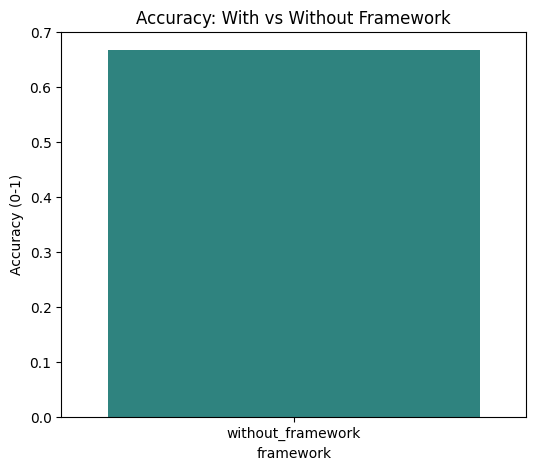


 DETAILED: RUN x FRAMEWORK INTERACTION
                              mental_demand  physical_demand  temporal_demand  \
run_number framework                                                            
1          without_framework            3.0              3.0              4.0   
4          without_framework            2.0              1.0              3.0   

                              performance  effort  frustration  
run_number framework                                            
1          without_framework          3.0     3.0          3.0  
4          without_framework          4.0     2.0          2.0  


In [9]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================

# Define which files correspond to which "Logical Run"
# We will extract specific runs from these files as requested.
# If the file contains multiple runs, we filter for the target.
# If the file resets run numbers (e.g. records Run 4 as Run 1), set force_override=True.
TARGET_FILES = {
    # "filename_part": (target_run_number, force_override)
    "bb426a": (1, False),  # Search for Run 1 in this file
    "009339": (4, False)   # Search for Run 4 in this file
}

# Answer Key
answer_key = {
    1: {1: "Yes", 2: "SW", 3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"},
    2: {1: {"Robot 1", "Robot 3"}, 2: "Robot 3 is encountering bad weather", 3: "Robot 2"},
    3: {1: "Replanning due to bad weather", 2: "Robot 2 will have to replan its route", 3: "Robot 2"},
    4: {1: "NE", 2: "Robot 3 discovered a package in the NE and is delivering it to the NW", 3: "NW"},
    5: {1: "Just delivered a package", 2: "Robot 2 will head towards a different package in the SW quadrant", 3: "Robot 2"},
    6: {1: {"Robot 2", "Robot 3"}, 2: "Both robots are experiencing poor weather", 3: "Robot 3 will return to the SE"}
}

def normalize(val):
    if isinstance(val, str):
        val = val.lower().strip()
        for prefix in ["a. ", "b. ", "c. ", "d. "]:
            if val.startswith(prefix): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    if correct_answer is None: return False
    
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            return {normalize(x) for x in user_answer} == {normalize(x) for x in correct_answer}
        return False
    return normalize(user_answer) == normalize(correct_answer)

# ==========================================
# 2. DATA LOADING
# ==========================================

tlx_data = []
accuracy_data = []

# Get all json files
files = glob.glob('*.json')

print(f"Found {len(files)} files. Filtering for targets...")

for file_path in files:
    # Check if this file is one of our targets
    target_run = None
    force_override = False
    
    # Match filename against our configuration
    for key, (tr, fo) in TARGET_FILES.items():
        if key in file_path:
            target_run = tr
            force_override = fo
            break
    
    # If this file isn't in our target list, skip it (or comment this out to process all files)
    if target_run is None:
        continue

    print(f"Processing {file_path} -> Extracting Run {target_run}")

    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except:
            print(f"Error loading {file_path}")
            continue

    for entry in data:
        # Get the run number from the JSON entry
        current_run = entry.get('run_number')
        
        # LOGIC: 
        # 1. If we are forcing override, we treat ALL data in this file as the target_run.
        # 2. If not forcing, we only keep data where entry['run_number'] matches target_run.
        
        if force_override:
            effective_run = target_run
        else:
            if current_run != target_run:
                continue
            effective_run = current_run

        etype = entry.get('type')
        
        # --- NASA-TLX (Post Scenario) ---
        if etype == 'post_scenario':
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'run_number': effective_run,
                'framework': entry.get('framework', 'unknown'),
                'view_type': entry.get('view_type', 'unknown')
            }
            
            # Parse TLX scores
            for metric in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
                val_str = answers.get(metric)
                if val_str:
                    try:
                        row[metric] = int(val_str.split(' - ')[0])
                    except:
                        row[metric] = None
            tlx_data.append(row)

        # --- ACCURACY (Pause Question) ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            q_idx = entry.get('pause_point')
            is_correct = check_answer(scenario, q_idx, entry.get('answer'))
            
            accuracy_data.append({
                'file': file_path,
                'run_number': effective_run,
                'scenario': scenario,
                'question': q_idx,
                'is_correct': is_correct
            })

# Merge framework info into accuracy data
df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

if not df_acc.empty and not df_tlx.empty:
    # Map (file, run) -> framework/view_type
    meta_map = df_tlx.set_index(['file', 'run_number'])[['framework', 'view_type']].to_dict('index')
    
    def get_meta(row):
        key = (row['file'], row['run_number'])
        if key in meta_map:
            return pd.Series(meta_map[key])
        return pd.Series(['unknown', 'unknown'], index=['framework', 'view_type'])

    df_acc[['framework', 'view_type']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 3. ANALYSIS & VISUALIZATION
# ==========================================

tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']

# --- PART A: RUN 1 vs RUN 4 ---
print("\n" + "="*40)
print(" COMPARISON: RUN 1 vs RUN 4")
print("="*40)

if not df_tlx.empty:
    # 1. TLX Stats
    print("\n--- NASA-TLX Scores (Run 1 vs Run 4) ---")
    run_comparison = df_tlx.groupby('run_number')[tlx_cols].mean().round(2)
    display(run_comparison)

    # Plot TLX
    df_melt_run = df_tlx.melt(id_vars=['run_number'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melt_run, x='Metric', y='Score', hue='run_number', palette="coolwarm", ci=None)
    plt.title("Workload: Run 1 vs Run 4")
    plt.ylim(0, 6)
    plt.show()

if not df_acc.empty:
    # 2. Accuracy Stats
    print("\n--- Accuracy % (Run 1 vs Run 4) ---")
    acc_run = df_acc.groupby('run_number')['is_correct'].mean() * 100
    print(acc_run)

    # Plot Accuracy
    plt.figure(figsize=(6, 5))
    acc_plot_run = df_acc.groupby('run_number')['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot_run, x='run_number', y='is_correct', palette="coolwarm")
    plt.title("Accuracy: Run 1 vs Run 4")
    plt.ylabel("Accuracy (0-1)")
    plt.show()


# --- PART B: WITH vs WITHOUT FRAMEWORK ---
print("\n" + "="*40)
print(" COMPARISON: WITH FRAMEWORK vs WITHOUT")
print("="*40)

if not df_tlx.empty:
    # 1. TLX Stats
    print("\n--- NASA-TLX Scores (Framework) ---")
    fw_comparison = df_tlx.groupby('framework')[tlx_cols].mean().round(2)
    display(fw_comparison)

    # Plot TLX
    df_melt_fw = df_tlx.melt(id_vars=['framework'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melt_fw, x='Metric', y='Score', hue='framework', palette="viridis", ci=None)
    plt.title("Workload: With vs Without Framework")
    plt.ylim(0, 6)
    plt.show()

if not df_acc.empty:
    # 2. Accuracy Stats
    print("\n--- Accuracy % (Framework) ---")
    acc_fw = df_acc.groupby('framework')['is_correct'].mean() * 100
    print(acc_fw)

    # Plot Accuracy
    plt.figure(figsize=(6, 5))
    acc_plot_fw = df_acc.groupby('framework')['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot_fw, x='framework', y='is_correct', palette="viridis")
    plt.title("Accuracy: With vs Without Framework")
    plt.ylabel("Accuracy (0-1)")
    plt.show()

# --- PART C: INTERACTION (Run x Framework) ---
if not df_tlx.empty:
    print("\n" + "="*40)
    print(" DETAILED: RUN x FRAMEWORK INTERACTION")
    print("="*40)
    print(df_tlx.groupby(['run_number', 'framework'])[tlx_cols].mean().round(2))

Scanning 2 files...

=== Accuracy by Study Stage ===
run_stage
End (Run 4)      83.333333
Start (Run 1)    66.666667
Name: is_correct, dtype: float64


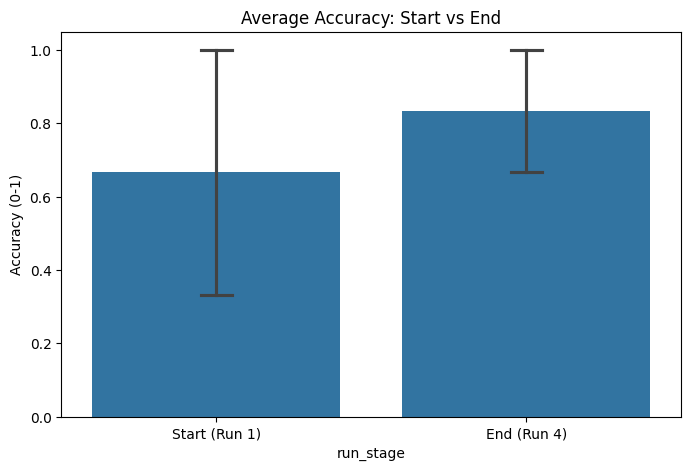


=== NASA-TLX Workload Comparison ===
               mental_demand  physical_demand  temporal_demand  performance  \
run_stage                                                                     
End (Run 4)              2.5              2.0              3.5          3.5   
Start (Run 1)            2.0              2.0              3.0          4.0   

               effort  frustration  
run_stage                           
End (Run 4)       2.5          2.5  
Start (Run 1)     2.0          2.0  


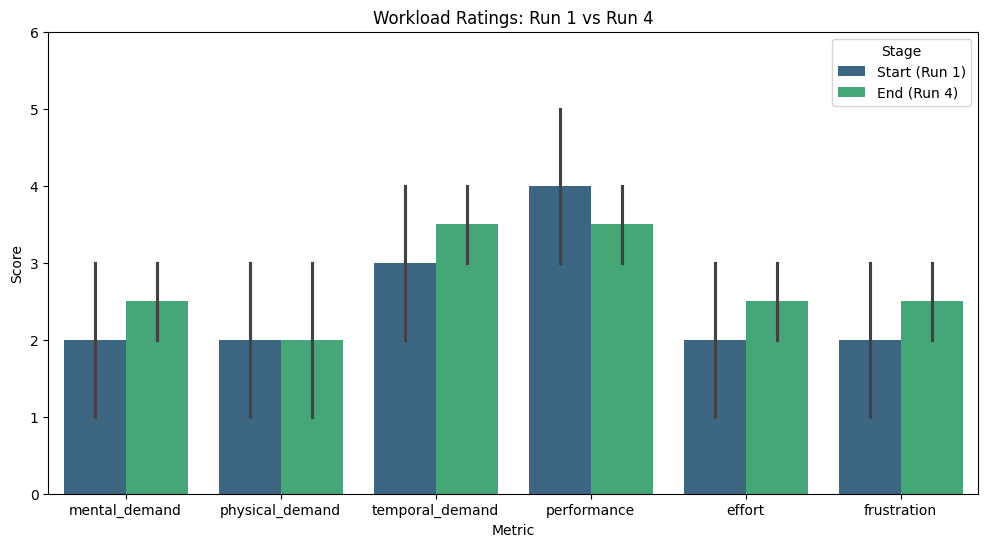


--- Sample Count (Number of Responses) ---
run_stage
Start (Run 1)    2
End (Run 4)      2
Name: count, dtype: int64


In [14]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP & ANSWER KEY
# ==========================================
answer_key = {
    1: {1: "Yes", 2: "SW", 3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"},
    2: {1: {"Robot 1", "Robot 3"}, 2: "Robot 3 is encountering bad weather", 3: "Robot 2"},
    3: {1: "Replanning due to bad weather", 2: "Robot 2 will have to replan its route", 3: "Robot 2"},
    4: {1: "NE", 2: "Robot 3 discovered a package in the NE and is delivering it to the NW", 3: "NW"},
    5: {1: "Just delivered a package", 2: "Robot 2 will head towards a different package in the SW quadrant", 3: "Robot 2"},
    6: {1: {"Robot 2", "Robot 3"}, 2: "Both robots are experiencing poor weather", 3: "Robot 3 will return to the SE"}
}

def normalize(val):
    if isinstance(val, str):
        val = val.lower().strip()
        for prefix in ["a. ", "b. ", "c. ", "d. "]:
            if val.startswith(prefix): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    if correct_answer is None: return False
    
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            return {normalize(x) for x in user_answer} == {normalize(x) for x in correct_answer}
        return False
    return normalize(user_answer) == normalize(correct_answer)

# ==========================================
# 2. DATA LOADING (Flexible - No Pairing Required)
# ==========================================

tlx_data = []
accuracy_data = []

files = glob.glob('*.json')
print(f"Scanning {len(files)} files...")

for file_path in files:
    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except:
            continue

    # We assume valid data if it contains ANY identifiable runs
    for entry in data:
        run_num = entry.get('run_number')
        
        # Only care about Run 1 and Run 4
        if run_num not in [1, 4]:
            continue
            
        stage_label = 'Start (Run 1)' if run_num == 1 else 'End (Run 4)'
        etype = entry.get('type')
        
        # --- Collect NASA-TLX ---
        if etype == 'post_scenario':
            answers = entry.get('answers', {})
            row = {
                'file_source': file_path,
                'run_stage': stage_label,
                'run_number': run_num,
                'framework': entry.get('framework'),
                'view_type': entry.get('view_type')
            }
            # Parse scores
            for metric in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
                val_str = answers.get(metric)
                if val_str:
                    try:
                        row[metric] = int(val_str.split(' - ')[0])
                    except:
                        row[metric] = None
            tlx_data.append(row)

        # --- Collect Accuracy ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            q_idx = entry.get('pause_point')
            is_correct = check_answer(scenario, q_idx, entry.get('answer'))
            
            accuracy_data.append({
                'file_source': file_path,
                'run_stage': stage_label,
                'run_number': run_num,
                'scenario': scenario,
                'question': q_idx,
                'is_correct': is_correct
            })

df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

# ==========================================
# 3. ANALYSIS: GROUP COMPARISON
# ==========================================

# --- A. ACCURACY ---
if not df_acc.empty:
    print("\n=== Accuracy by Study Stage ===")
    # Calculate average accuracy for ALL Run 1s vs ALL Run 4s
    acc_stats = df_acc.groupby('run_stage')['is_correct'].mean() * 100
    print(acc_stats)
    
    # Plot
    plt.figure(figsize=(8, 5))
    acc_plot = df_acc.groupby(['file_source', 'run_stage'])['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot, x='run_stage', y='is_correct', order=['Start (Run 1)', 'End (Run 4)'], capsize=.1)
    plt.title("Average Accuracy: Start vs End")
    plt.ylabel("Accuracy (0-1)")
    plt.show()

# --- B. NASA-TLX WORKLOAD ---
if not df_tlx.empty:
    print("\n=== NASA-TLX Workload Comparison ===")
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    # Calculate Means
    print(df_tlx.groupby('run_stage')[tlx_cols].mean().round(2))

    # Plot
    df_melt = df_tlx.melt(id_vars=['run_stage'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='run_stage', 
                hue_order=['Start (Run 1)', 'End (Run 4)'], palette="viridis")
    plt.title("Workload Ratings: Run 1 vs Run 4")
    plt.ylim(0, 6)
    plt.legend(title="Stage")
    plt.show()
    
    # --- C. DETAILED BREAKDOWN (Optional) ---
    # Since files are split, we print a count to ensure data is balanced
    print("\n--- Sample Count (Number of Responses) ---")
    print(df_tlx['run_stage'].value_counts())

Found 2 JSON files.

Processed 2 valid complete files.

--- NASA-TLX Statistics (Mean Scores) ---


mental_demand  physical_demand  temporal_demand  \
framework         view_type                                                    
with_framework    map                  1.5              1.5              2.5   
                  text                 2.5              2.5              3.0   
without_framework map                  2.5              2.0              3.5   
                  text                 4.0              3.0              4.0   

                             performance  effort  frustration  
framework         view_type                                    
with_framework    map                4.5     2.0          1.5  
                  text               3.5     2.5          2.0  
without_framework map                3.5     2.5          2.5  
                  text               3.0     4.0          3.5

/tmp/ipykernel_119295/240326228.py:204: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")


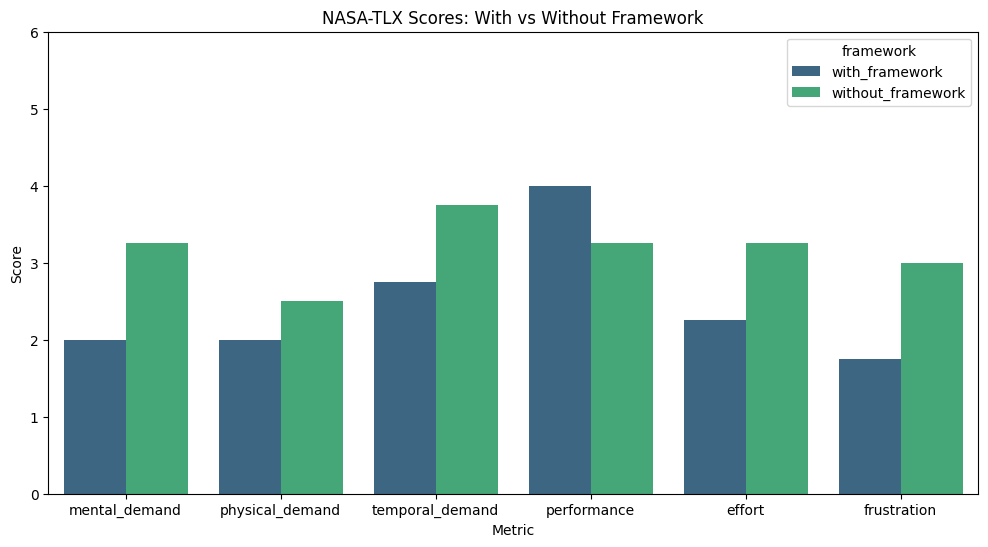

/tmp/ipykernel_119295/240326228.py:210: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")


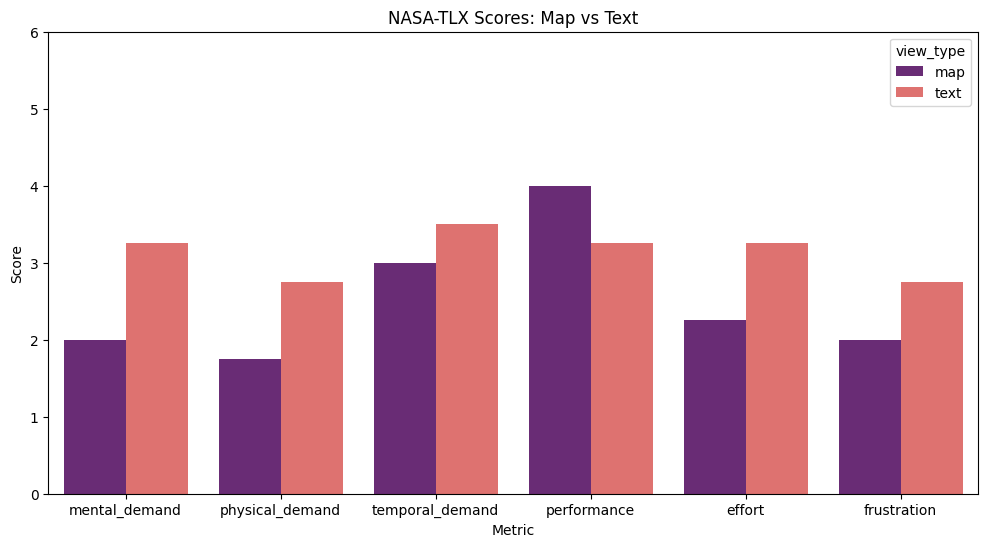


--- Accuracy Statistics ---
Overall Accuracy: 62.50%

Accuracy by Scenario (%):
scenario
1    66.666667
2    33.333333
3    66.666667
4    83.333333
Name: is_correct, dtype: float64

Accuracy by Framework (%):
framework
with_framework       75.0
without_framework    50.0
Name: is_correct, dtype: float64

Accuracy by View Type (%):
view_type
map     66.666667
text    58.333333
Name: is_correct, dtype: float64


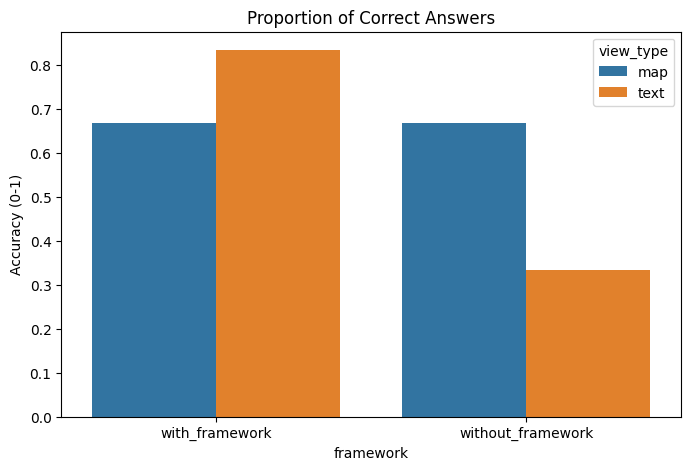

In [13]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & ANSWER KEY DEFINITION
# ==========================================

# Define the answer key based on your prompt
# Note: For array answers (multiple checkboxes), we use sets for comparison.
answer_key = {
    1: {
        1: "Yes",
        2: "SW",
        3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"
    },
    2: {
        1: {"Robot 1", "Robot 3"}, # Set for order-independent comparison
        2: "Robot 3 is encountering bad weather",
        3: "Robot 2"
    },
    3: {
        1: "Replanning due to bad weather",
        2: "Robot 2 will have to replan its route",
        3: "Robot 2"
    },
    4: {
        1: "NE",
        2: "Robot 3 discovered a package in the NE and is delivering it to the NW",
        3: "NW"
    },
    5: {
        1: "Just delivered a package",
        2: "Robot 2 will head towards a different package in the SW quadrant",
        3: "Robot 2"
    },
    6: {
        1: {"Robot 2", "Robot 3"},
        2: "Both robots are experiencing poor weather",
        3: "Robot 3 will return to the SE"
    }
}

# Helper to normalize answers for comparison (removes case sensitivity, extra whitespace)
def normalize(val):
    if isinstance(val, str):
        # Remove potential prefixes like "b. " if they exist in user data but not key
        val = val.lower().strip()
        if val.startswith("b. "): val = val[3:]
        if val.startswith("a. "): val = val[3:]
        if val.startswith("c. "): val = val[3:]
        if val.startswith("d. "): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    
    if correct_answer is None:
        return False # No key found for this scenario/question
    
    # Handle List/Set answers (Multiple Selection)
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            # Normalize user list to set
            user_set = {normalize(x) for x in user_answer}
            # Normalize correct set
            correct_set = {normalize(x) for x in correct_answer}
            return user_set == correct_set
        return False

    # Handle String answers
    return normalize(user_answer) == normalize(correct_answer)


# ==========================================
# 2. DATA LOADING & FILTERING
# ==========================================

# List to store parsed data
tlx_data = []      # For NASA-TLX stats
accuracy_data = [] # For Right/Wrong counts

# Get all json files in current directory
files = glob.glob('*.json')
print(f"Found {len(files)} JSON files.")

valid_files_count = 0

for file_path in files:
    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Skipping {file_path}: Invalid JSON")
            continue

    # 2a. Filter: Check for 'post_study' to ensure completion
    # We look for any entry in the list with type == 'post_study'
    is_complete = any(entry.get('type') == 'post_study' for entry in data)
    
    if not is_complete:
        print(f"Skipping {file_path}: Incomplete study (no post_study tag)")
        continue
        
    valid_files_count += 1
    
    # 2b. Process Entries
    for entry in data:
        etype = entry.get('type')
        
        # --- PROCESS NASA-TLX (Post Scenario) ---
        if etype == 'post_scenario':
            # Extract basic info
            framework = entry.get('framework')
            view_type = entry.get('view_type')
            scenario = entry.get('scenario')
            run_number = entry.get('run_number')
            
            # Parse TLX scores (Extract number from string "3 - Moderate")
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'framework': framework,
                'view_type': view_type,
                'scenario': scenario,
                'run_number': run_number
            }
            
            for metric, value_str in answers.items():
                if value_str and isinstance(value_str, str):
                    # Take the first character and convert to int
                    try:
                        score = int(value_str.split(' - ')[0])
                        row[metric] = score
                    except:
                        row[metric] = None
            
            tlx_data.append(row)

        # --- PROCESS ACCURACY (Pause Question) ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            pause_point = entry.get('pause_point') # This maps to Question 1, 2, 3
            user_ans = entry.get('answer')
            framework = "Unknown" # Usually defined in post_scenario, might need lookahead/lookbehind if critical here
            # Note: The JSON structure has 'framework' in post_scenario, not pause_question. 
            # If you need to correlate accuracy with framework, we might need to map run_number to framework from the post_scenario entries.
            
            is_correct = check_answer(scenario, pause_point, user_ans)
            
            accuracy_data.append({
                'file': file_path,
                'scenario': scenario,
                'question': pause_point,
                'user_answer': user_ans,
                'is_correct': is_correct,
                'run_number': entry.get('run_number')
            })

print(f"\nProcessed {valid_files_count} valid complete files.")

# ==========================================
# 3. MERGE FRAMEWORK INFO INTO ACCURACY
# ==========================================
# Since 'pause_question' doesn't have 'framework' or 'view_type', 
# we create a mapping from (file, run_number) -> (framework, view_type) using the tlx_data
df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

if not df_tlx.empty and not df_acc.empty:
    # Create mapping dictionary
    run_info_map = df_tlx.set_index(['file', 'run_number'])[['framework', 'view_type']].to_dict('index')

    def get_meta(row):
        key = (row['file'], row['run_number'])
        if key in run_info_map:
            return pd.Series(run_info_map[key])
        return pd.Series([None, None], index=['framework', 'view_type'])

    df_acc[['framework', 'view_type']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 4. ANALYSIS & VISUALIZATION
# ==========================================

# --- A. NASA-TLX STATS ---
if not df_tlx.empty:
    print("\n--- NASA-TLX Statistics (Mean Scores) ---")
    # Group by Framework and View Type
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    grouped_tlx = df_tlx.groupby(['framework', 'view_type'])[tlx_cols].mean().round(2)
    display(grouped_tlx)

    # Plotting
    # Melt for seaborn
    df_melt = df_tlx.melt(id_vars=['framework', 'view_type'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")
    plt.title("NASA-TLX Scores: With vs Without Framework")
    plt.ylim(0, 6) # Assuming 1-5 or 0-6 scale
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")
    plt.title("NASA-TLX Scores: Map vs Text")
    plt.ylim(0, 6)
    plt.show()

# --- B. ACCURACY STATS ---
if not df_acc.empty:
    print("\n--- Accuracy Statistics ---")
    
    # Overall % Correct
    overall_acc = df_acc['is_correct'].mean() * 100
    print(f"Overall Accuracy: {overall_acc:.2f}%")
    
    # Accuracy by Scenario
    acc_by_scenario = df_acc.groupby('scenario')['is_correct'].mean() * 100
    print("\nAccuracy by Scenario (%):")
    print(acc_by_scenario)
    
    # Accuracy by Framework/View Type
    if 'framework' in df_acc.columns:
        print("\nAccuracy by Framework (%):")
        print(df_acc.groupby('framework')['is_correct'].mean() * 100)
        
        print("\nAccuracy by View Type (%):")
        print(df_acc.groupby('view_type')['is_correct'].mean() * 100)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    acc_plot_data = df_acc.groupby(['framework', 'view_type'])['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot_data, x='framework', y='is_correct', hue='view_type')
    plt.title("Proportion of Correct Answers")
    plt.ylabel("Accuracy (0-1)")
    plt.show()